In [2]:
import pandas as pd
from sklearn.utils import resample

# Load full failure label file
df = pd.read_csv("ssd_failure_label.csv")

# Set target total number of samples
target_total = 1500

# Count per model
model_counts = df['model'].value_counts()
total_count = model_counts.sum()

# Show original model distribution
print("Original model distribution:")
print(model_counts)

# Proportional sampling
sampled_df = pd.DataFrame()
for model, count in model_counts.items():
    target = int(target_total * (count / total_count))
    group = df[df['model'] == model]
    if len(group) > target:
        sampled = resample(group, replace=False, n_samples=target, random_state=42)
    else:
        sampled = group
    sampled_df = pd.concat([sampled_df, sampled])

# Shuffle and reset index
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to default filename
sampled_df.to_csv("sampled_failure_label_weighted.csv", index=False)

# Display summary
print("\nSample count per model (after sampling):")
print(sampled_df['model'].value_counts())
print("\nFirst 5 rows:")
print(sampled_df.head())
print(f"\nTotal samples: {len(sampled_df)}")
print(f"Unique disk_id count: {sampled_df['disk_id'].nunique()}")


Original model distribution:
model
MC1    10510
MB1     1807
MA1     1370
MC2     1131
MA2      883
MB2      604
Name: count, dtype: int64

Sample count per model (after sampling):
model
MC1    966
MB1    166
MA1    126
MC2    104
MA2     81
MB2     55
Name: count, dtype: int64

First 5 rows:
  model         failure_time  disk_id
0   MB1  2019-06-15 09:03:58    20022
1   MC2  2018-11-22 09:59:47    18094
2   MA2  2019-03-22 10:31:13    52160
3   MB2  2019-04-09 02:57:19    29516
4   MC1  2019-09-15 19:42:34   125742

Total samples: 1498
Unique disk_id count: 1494


In [1]:
# Load the dataset
import pandas as pd
df = pd.read_csv('sample_index.csv')

# Count the number of samples for each label
label_counts = df['label'].value_counts().sort_index()


print(df.head())
print("Label distribution:")
print(label_counts)


   disk_id model        date  label
0      240   MC1  2019-01-01      1
1      259   MA1  2019-03-12      0
2      259   MB1  2019-03-13      0
3      259   MA1  2019-03-14      0
4      259   MB1  2019-03-15      1
Label distribution:
label
0    15947
1     6559
Name: count, dtype: int64


In [1]:
import pandas as pd
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

sample_index_path = 'sample_index.csv'
log_dir = 'smartlog2019ssd'
df_index = pd.read_csv(sample_index_path, parse_dates=['date'])
df_index['disk_id'] = df_index['disk_id'].astype(str)

# Group by date
grouped = df_index.groupby(df_index['date'].dt.strftime('%Y%m%d'))

# Extract SMART features
smart_data = []
print("Extract SMART features：")
for date_str, group in tqdm(grouped, total=len(grouped)):
    file_path = os.path.join(log_dir, f"{date_str}.csv")
    if not os.path.exists(file_path):
        continue
    try:
        df_log = pd.read_csv(file_path)
        df_log['disk_id'] = df_log['disk_id'].astype(str)
    except:
        continue
    merged = pd.merge(group, df_log, on='disk_id', how='inner')
    smart_data.append(merged)

# Merge
df_feat = pd.concat(smart_data, ignore_index=True)

# Retain SMART fields with a non-missing rate of ≥ 70%
smart_cols = [col for col in df_feat.columns if col.startswith("r_")]
valid_cols = [col for col in smart_cols if df_feat[col].notnull().mean() >= 0.7]

print(f"\nTotal sample size：{len(df_feat)}")
print(f"The number of valid SMART attributes：{len(valid_cols)}")

df_feat = df_feat[valid_cols + ["disk_id", "label"]]
X = df_feat.drop(columns=["disk_id", "label"])
y = df_feat["label"]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X, y)

# Top 10 
importances = rf.feature_importances_
sorted_features = sorted(zip(importances, X.columns), reverse=True)

print("\nTop 10 SMART Attribute importance：")
for i, (score, name) in enumerate(sorted_features[:10], 1):
    print(f"{i:2d}. {name:<10}: {score:.4f}")
    
# top10 DataFrame
top10_df = pd.DataFrame(sorted_features[:10], columns=["importance", "attribute"])


Extract SMART features：


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [22:07<00:00,  3.77s/it]



Total sample size：51536
The number of valid SMART attributes：14

Top 10 SMART Attribute importance：
 1. r_9       : 0.5897
 2. r_12      : 0.1031
 3. r_194     : 0.0861
 4. r_174     : 0.0787
 5. r_180     : 0.0754
 6. r_195     : 0.0249
 7. r_199     : 0.0159
 8. r_5       : 0.0125
 9. r_171     : 0.0073
10. r_183     : 0.0026


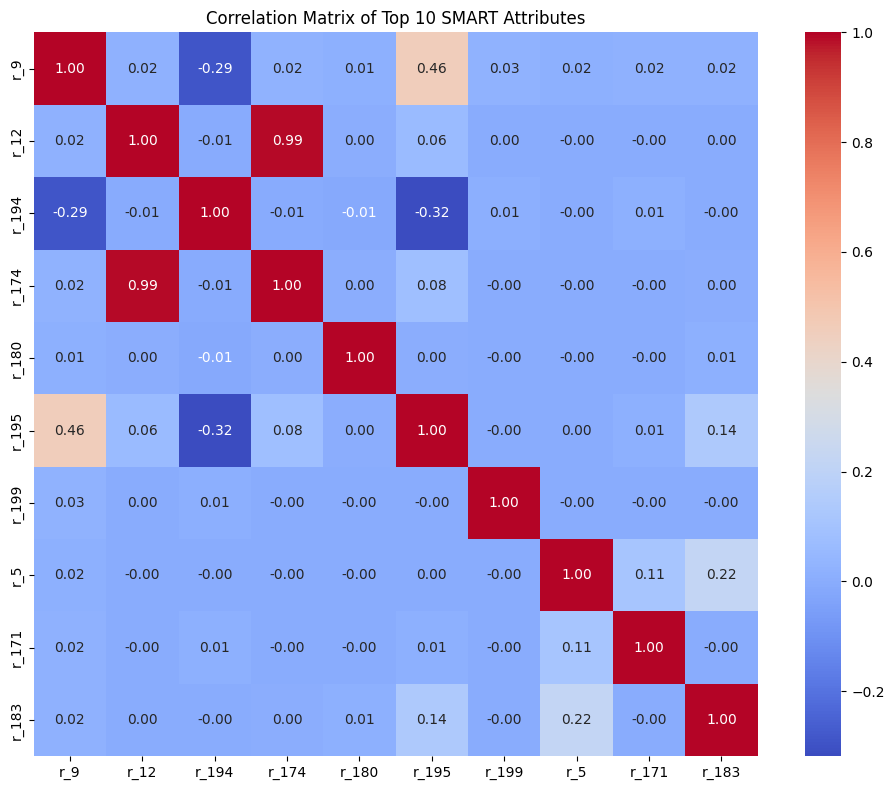

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# top10 DataFrame
top10_attrs = top10_df["attribute"].tolist()

# Extract the corresponding columns for correlation analysis
df_top10 = df_feat[top10_attrs].copy()

# Calculate the Pearson correlation coefficient matrix
corr_matrix = df_top10.corr(method='pearson')

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Matrix of Top 10 SMART Attributes")
plt.tight_layout()
plt.show()


In [3]:
# Feature construction
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Config
sample_index_path = 'sample_index.csv'
cleaned_log_dir = 'cleaned_logs'
output_path = 'features_test.csv'
window_days = 10  # Lookback window
selected_attrs = ['r_5', 'r_9', 'r_12', 'r_197', 'r_180', 'r_194', 'r_174']  
# Load sample index 
df_index = pd.read_csv(sample_index_path, parse_dates=['date'])
df_index['disk_id'] = df_index['disk_id'].astype(str)
df_index['date_str'] = df_index['date'].dt.strftime('%Y%m%d')
df_index = df_index.reset_index(drop=True)

# Feature extraction function 
def extract_features_for_sample(disk_id, target_date):
    features = {'disk_id': disk_id, 'date': target_date}
    collected = []

    for offset in range(1, window_days + 1):
        day = target_date - pd.Timedelta(days=offset)
        day_str = day.strftime('%Y%m%d')
        log_path = os.path.join(cleaned_log_dir, f'{day_str}.csv')
        if not os.path.exists(log_path):
            continue
        try:
            df_day = pd.read_csv(log_path)
            df_day['disk_id'] = df_day['disk_id'].astype(str)
            rows = df_day[df_day['disk_id'] == disk_id]
            if not rows.empty:
                collected.append(rows)
        except:
            continue

    if not collected:
        for attr in selected_attrs:
            for stat in ['mean', 'max', 'min', 'std', 'range', 'slope', 'skew', 'kurtosis']:
                features[f"{attr}_{stat}"] = np.nan
        features['diff_12_174'] = np.nan
        features['prod_12_174'] = np.nan
        return features

    all_data = pd.concat(collected, ignore_index=True)
    numeric_cols = [col for col in all_data.select_dtypes(include=[np.number]).columns if col in selected_attrs]

    for attr in numeric_cols:
        series = all_data[attr].dropna()
        if len(series) < 3 or series.nunique() <= 1:
            for stat in ['mean', 'max', 'min', 'std', 'range', 'slope', 'skew', 'kurtosis']:
                features[f"{attr}_{stat}"] = np.nan
            continue

        features[f"{attr}_mean"] = series.mean()
        features[f"{attr}_max"] = series.max()
        features[f"{attr}_min"] = series.min()
        features[f"{attr}_std"] = series.std()
        features[f"{attr}_range"] = series.max() - series.min()
        features[f"{attr}_slope"] = np.polyfit(range(len(series)), series, 1)[0]
        features[f"{attr}_skew"] = skew(series)
        features[f"{attr}_kurtosis"] = kurtosis(series)

    try:
        s12 = all_data['r_12'].dropna()
        s174 = all_data['r_174'].dropna()
        features['diff_12_174'] = s12.mean() - s174.mean() if len(s12) > 0 and len(s174) > 0 else np.nan
        features['prod_12_174'] = (s12 * s174).mean() if len(s12) == len(s174) and len(s12) > 0 else np.nan
    except:
        features['diff_12_174'] = np.nan
        features['prod_12_174'] = np.nan

    return features

# Extract features with progress bar 
all_features = []
for _, row in tqdm(df_index.iterrows(), total=len(df_index), desc="Extracting test features"):
    result = extract_features_for_sample(row['disk_id'], row['date'])
    result['label'] = row['label']
    result['model'] = row['model']
    all_features.append(result)

# Save 
df_feat = pd.DataFrame(all_features)
df_feat.to_csv(output_path, index=False)
print(f"Saved test feature set to {output_path}, total samples: {len(df_feat)}")


Extracting test features: 100%|██████████████████████████████████████████████████| 22506/22506 [10:19<00:00, 36.33it/s]


Saved test feature set to features_test.csv, total samples: 22506


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Input & Output Path 
input_feature_path = 'features_test.csv'
output_ml_path = 'ml_features.csv'            

# Load Feature Data 
df = pd.read_csv(input_feature_path)

# Retain these non-numeric fields
metadata_cols = ['disk_id', 'model', 'date', 'label']
feature_cols = [col for col in df.columns if col not in metadata_cols and df[col].dtype != 'object']

# Z-score Normalization 
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[feature_cols]), columns=feature_cols)

# Reconstruct Final DataFrame 
df_final = pd.concat([df[metadata_cols].reset_index(drop=True), df_scaled.reset_index(drop=True)], axis=1)

# Save to ML Format CSV 
df_final.to_csv(output_ml_path, index=False)
print(f"Saved ML-compatible feature file to: {output_ml_path}")


Saved ML-compatible feature file to: ml_features.csv


In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Config
sample_index_path = 'sample_index.csv'  
cleaned_log_dir = 'cleaned_logs'        
output_sequence_csv = 'dl_sequences.csv'
window_days = 10  
selected_attrs = ['r_5', 'r_9', 'r_12', 'r_197', 'r_180', 'r_194', 'r_174']

# Sample index
df_index = pd.read_csv(sample_index_path, parse_dates=['date'])
df_index['disk_id'] = df_index['disk_id'].astype(str)
df_index['date_str'] = df_index['date'].dt.strftime('%Y%m%d')

df_index = df_index.reset_index(drop=True)

# Build sliding window features
sequence_rows = []

for idx, row in tqdm(df_index.iterrows(), total=len(df_index), desc="Building LSTM sequences"):
    disk_id = row['disk_id']
    model = row['model']
    label = row['label']
    target_date = row['date']
    
    sequence = {'disk_id': disk_id, 'model': model, 'date': target_date, 'label': label}
    
    for offset in range(window_days, 0, -1):
        day = target_date - pd.Timedelta(days=offset)
        day_str = day.strftime('%Y%m%d')
        file_path = os.path.join(cleaned_log_dir, f"{day_str}.csv")

        for attr in selected_attrs:
            col_name = f"{attr}_t-{offset}"
            if os.path.exists(file_path):
                try:
                    df_log = pd.read_csv(file_path)
                    df_log['disk_id'] = df_log['disk_id'].astype(str)
                    row_log = df_log[df_log['disk_id'] == disk_id]
                    value = row_log[attr].values[0] if not row_log.empty else np.nan
                except:
                    value = np.nan
            else:
                value = np.nan
            sequence[col_name] = value

    sequence_rows.append(sequence)

# Save
df_seq = pd.DataFrame(sequence_rows)
df_seq.to_csv(output_sequence_csv, index=False)
print(f"Saved LSTM sequence data to {output_sequence_csv}, shape = {df_seq.shape}")


Building LSTM sequences: 100%|███████████████████████████████████████████████████| 22506/22506 [53:48<00:00,  6.97it/s]


Saved LSTM sequence data to dl_sequences.csv, shape = (22506, 74)


In [8]:
df = pd.read_csv('ml_features.csv')
df.fillna(0, inplace=True)
print(df.head())

   disk_id model        date  label  r_5_mean   r_5_max   r_5_min  r_5_std  \
0      240   MC1  2019-01-01      1  0.000000  0.000000  0.000000  0.00000   
1      259   MA1  2019-03-12      0  0.000000  0.000000  0.000000  0.00000   
2      259   MB1  2019-03-13      0  0.000000  0.000000  0.000000  0.00000   
3      259   MA1  2019-03-14      0 -0.150422 -0.195855 -0.097863 -0.15703   
4      259   MB1  2019-03-15      1 -0.157090 -0.195855 -0.097863 -0.15703   

   r_5_range  r_5_slope  ...  r_174_mean  r_174_max  r_174_min  r_174_std  \
0   0.000000   0.000000  ...    0.000000   0.000000   0.000000   0.000000   
1   0.000000   0.000000  ...    0.000000   0.000000   0.000000   0.000000   
2   0.000000   0.000000  ...    0.000000   0.000000   0.000000   0.000000   
3  -0.173643  -0.070848  ...   -0.053883   0.074698   0.144609   0.133747   
4  -0.173643  -0.050505  ...    0.142981   0.074698   0.144609   0.133747   

   r_174_range  r_174_slope  r_174_skew  r_174_kurtosis  diff_12_174

In [9]:
df = pd.read_csv('dl_sequences.csv')
df.fillna(0, inplace=True)
print(df.head())

   disk_id model        date  label  r_5_t-10  r_9_t-10  r_12_t-10  \
0      240   MC1  2019-01-01      1       0.0       0.0        0.0   
1      259   MA1  2019-03-12      0       0.0       0.0        0.0   
2      259   MB1  2019-03-13      0       0.0       0.0        0.0   
3      259   MA1  2019-03-14      0       0.0       0.0        0.0   
4      259   MB1  2019-03-15      1       0.0       0.0        0.0   

   r_197_t-10  r_180_t-10  r_194_t-10  ...  r_180_t-2  r_194_t-2  r_174_t-2  \
0         0.0         0.0         0.0  ...        0.0        0.0        0.0   
1         0.0         0.0         0.0  ...        0.0        0.0        0.0   
2         0.0         0.0         0.0  ...        0.0        0.0        0.0   
3         0.0         0.0         0.0  ...    13363.0       20.0       27.0   
4         0.0         0.0         0.0  ...     7651.0       27.0       12.0   

   r_5_t-1  r_9_t-1  r_12_t-1  r_197_t-1  r_180_t-1  r_194_t-1  r_174_t-1  
0      0.0      0.0       0.

In [ ]:
#Machine Learning

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      3190
           1       0.91      0.89      0.90      1312

    accuracy                           0.94      4502
   macro avg       0.93      0.93      0.93      4502
weighted avg       0.94      0.94      0.94      4502



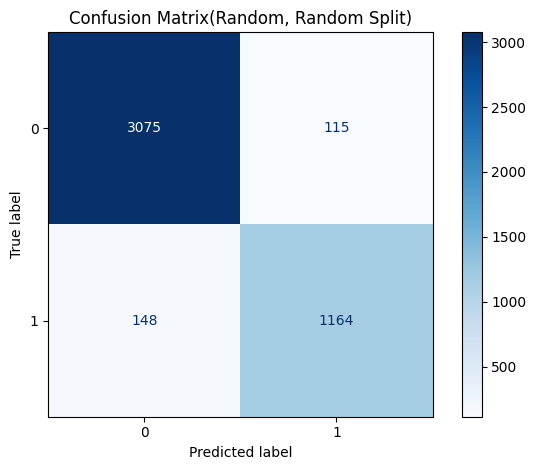

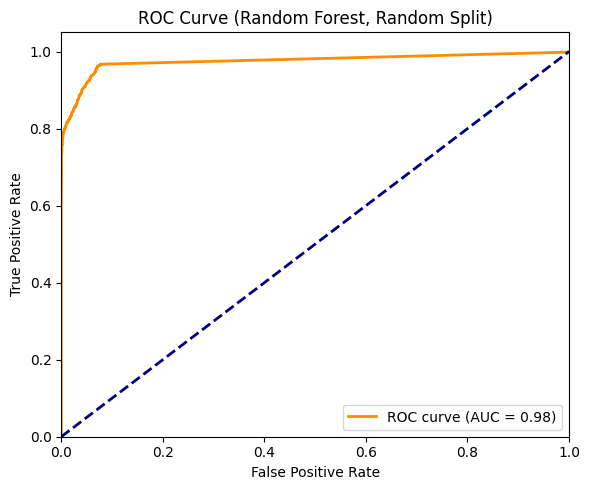

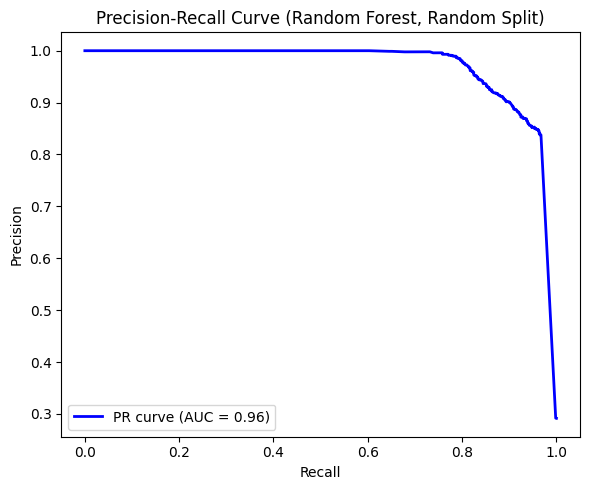

In [12]:
#Random Forest(Random split)
# Load Data
df = pd.read_csv('ml_features.csv')
df = df.drop(columns=['disk_id', 'date', 'model'])
df = df.fillna(0)

X = df.drop(columns=['label'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix(Random, Random Split)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest, Random Split)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)   # 计算AUC-PR

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'PR curve (AUC = {pr_auc:.2f})')  # 把数值加到图例里
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest, Random Split)')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

Train samples: 20651, Test samples: 1855
Train end date: 2019-10-09

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.87      0.73       587
           1       0.93      0.77      0.84      1268

    accuracy                           0.80      1855
   macro avg       0.78      0.82      0.79      1855
weighted avg       0.83      0.80      0.81      1855



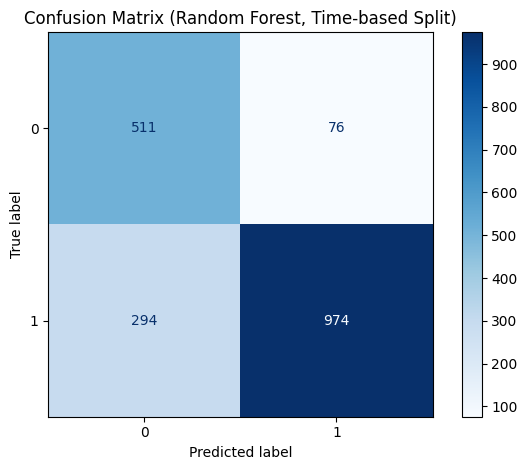

In [4]:
# Random Forest(Time-based split)
# Read and sort by time
df = pd.read_csv('ml_features.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# Time-ordered train/test split to avoid temporal leakage
unique_dates = df['date'].dt.normalize().unique()
train_ratio = 0.8
cut_idx = int(len(unique_dates) * train_ratio)
train_end_date = pd.to_datetime(unique_dates[cut_idx - 1])

train_df = df[df['date'].dt.normalize() <= train_end_date].copy()
test_df  = df[df['date'].dt.normalize() >  train_end_date].copy()

# Data processing
drop_cols = [c for c in ['disk_id', 'date', 'model'] if c in df.columns]
train_df = train_df.drop(columns=drop_cols).fillna(0)
test_df  = test_df.drop(columns=drop_cols).fillna(0)

X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test,  y_test  = test_df.drop(columns=['label']),  test_df['label']

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Train end date: {train_end_date.date()}")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Prediction and Report
y_pred = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Random Forest, Time-based Split)")
plt.tight_layout()
plt.show()

# ROC & PR
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
ap = average_precision_score(y_test, y_prob_rf)
pos_rate = (y_test == 1).mean()


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      3190
           1       0.84      0.96      0.90      1312

    accuracy                           0.94      4502
   macro avg       0.91      0.94      0.93      4502
weighted avg       0.94      0.94      0.94      4502



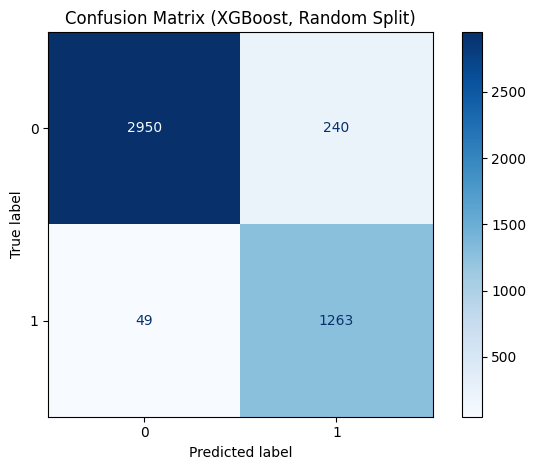

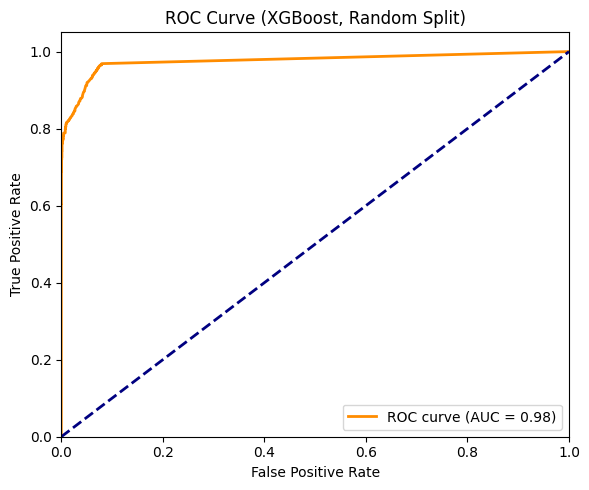

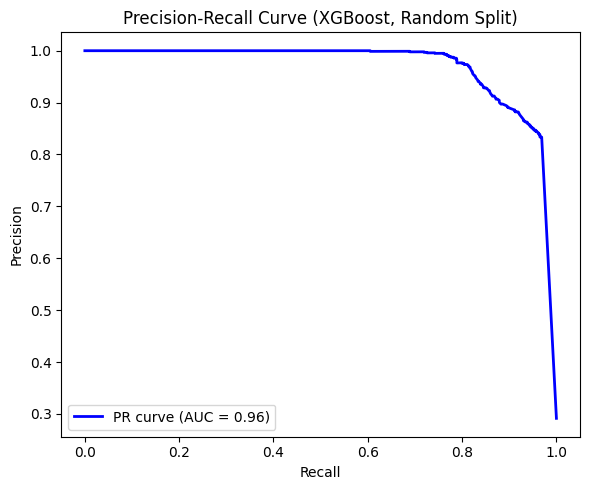

In [11]:
#XGBoost(Random split)

# Load data
df = pd.read_csv('ml_features.csv')

# Data processing
df = df.drop(columns=['disk_id', 'date', 'model'])
df = df.fillna(0)
X = df.drop(columns=['label'])
y = df['label']

# Random split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Construct DMatrix 
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Setup parameters
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',      
    'max_depth': 6,
    'eta': 0.1,
    'scale_pos_weight': float(scale_pos_weight),
    'random_state': 42
}

# Train model
bst = xgb.train(params, dtrain, num_boost_round=100)

y_prob = bst.predict(dtest)                
y_pred = (y_prob > 0.5).astype(int)        

# Report & Confusion Matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (XGBoost, Random Split)")
plt.tight_layout()
plt.show()
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost, Random Split)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost, Random Split)')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

Train samples: 20651, Test samples: 1855
Train end date: 2019-10-09

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71       587
           1       0.89      0.81      0.85      1268

    accuracy                           0.80      1855
   macro avg       0.77      0.79      0.78      1855
weighted avg       0.81      0.80      0.80      1855



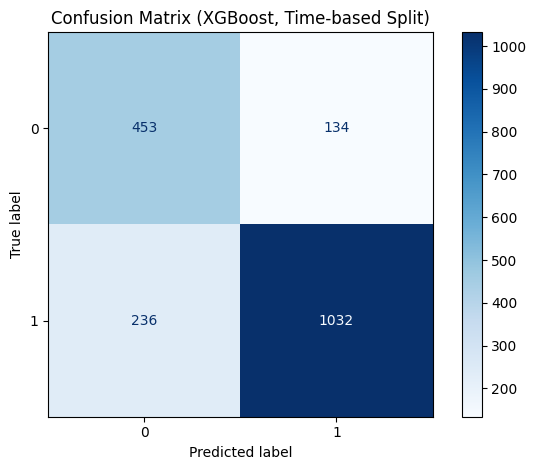

In [7]:
#XGBoost(Time-based split)
# Read and sort by time
df = pd.read_csv('ml_features.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# unique_dates
unique_dates = df['date'].dt.normalize().unique()
train_ratio = 0.8
cut_idx = int(len(unique_dates) * train_ratio)
train_end_date = pd.to_datetime(unique_dates[cut_idx - 1])

train_df = df[df['date'].dt.normalize() <= train_end_date].copy()
test_df  = df[df['date'].dt.normalize() >  train_end_date].copy()

# Data processing
drop_cols = [c for c in ['disk_id', 'date', 'model'] if c in df.columns]
train_df = train_df.drop(columns=drop_cols).fillna(0)
test_df  = test_df.drop(columns=drop_cols).fillna(0)

X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test,  y_test  = test_df.drop(columns=['label']),  test_df['label']

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Train end date: {train_end_date.date()}")

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Set up params
scale_pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',     
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': float(scale_pos_weight),
    'random_state': 42
}

# Train
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
  #evals=[(dtrain, 'train'), (dtest, 'test')],
  #  early_stopping_rounds=50,
    verbose_eval=False
)

#y_prob = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
#y_pred = (y_prob > 0.5).astype(int)

y_prob_xgb = bst.predict(dtest)          
y_pred = (y_prob_xgb >= 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (XGBoost, Time-based Split)")
plt.tight_layout()
plt.show()

# ROC & PR
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)
ap = average_precision_score(y_test, y_prob_xgb)
pos_rate = (y_test == 1).mean()

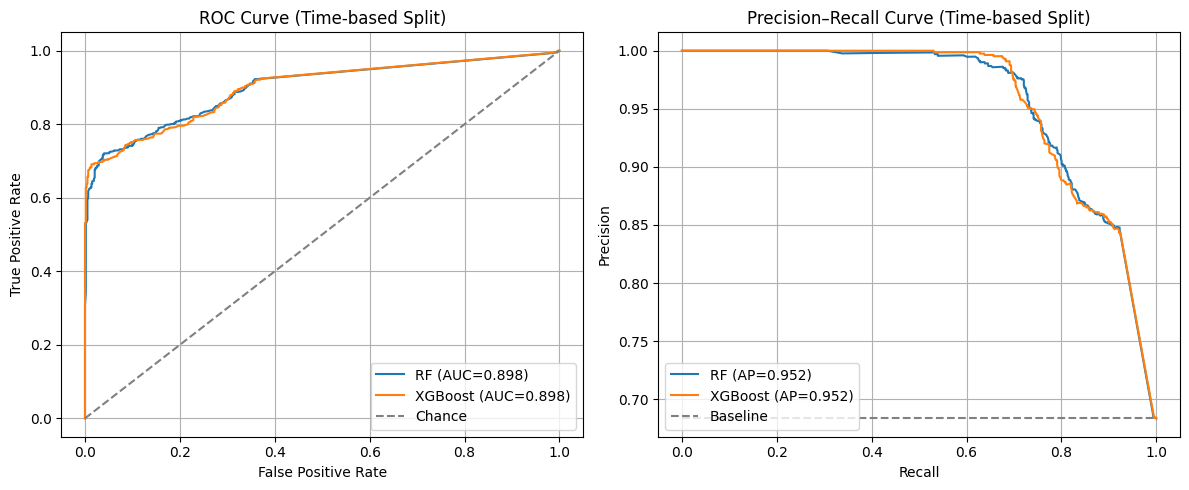

In [8]:
#The comparison of the ROC and PR curves of the random forest model and the XGBoost model 
# RF
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)
ap_rf = average_precision_score(y_test, y_prob_rf)

# XGB
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
ap_xgb = average_precision_score(y_test, y_prob_xgb)

pos_rate = (y_test == 1).mean()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- ROC comparison ---
axes[0].plot(fpr_rf,  tpr_rf,  label=f'RF (AUC={roc_auc_rf:.3f})')
axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_xgb:.3f})')
axes[0].plot([0, 1], [0, 1], '--', color='gray', label='Chance')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (Time-based Split)')
axes[0].legend()
axes[0].grid(True)

# --- PR comparison ---
axes[1].plot(rec_rf,  prec_rf,  label=f'RF (AP={ap_rf:.3f})')
axes[1].plot(rec_xgb, prec_xgb, label=f'XGBoost (AP={ap_xgb:.3f})')
axes[1].hlines(pos_rate, 0, 1, linestyles='--', color='gray', label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision–Recall Curve (Time-based Split)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()